In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

import data_cleaning

# Data loading / cleaning

## Loading..

**Getting POAP data and creating couple identifier columns**

In [2]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_proposals, dh_votes = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes, snap_creation = data_cleaning.get_snapshot_cleaned_data()

In [3]:
from datetime import datetime

#marking the top X% minters

top_minters = poap.groupby('owner_id').agg(poaps_minted=('token_id', 'nunique'), 
                                           unique_events_minted=('event_id', 'nunique')).reset_index().sort_values('poaps_minted', ascending=False)

percs = [.5, .4, .3, .2, .1]

top_minters['is_top_x%'] = ''
for perc in percs:
    perc_max_count = int(len(top_minters) * perc)
    top_minters.iloc[0:perc_max_count, 3] = f"{perc*100:.0f}%"

#merging poap dt with the new labels
poap = poap.merge(top_minters, on='owner_id', how='left')

#adding proper timeformat to mint_date
poap['mint_timestamp'] = poap['token_created'].apply(lambda t: datetime.fromtimestamp(t) )
poap['mint_date'] = poap['mint_timestamp'].dt.date

poap.head()

,token_created,event_created,event_id,event_tokenCount,event_transferCount,token_id,owner_id,token_transferCount,chain,event_fancy_id,...,virtual_event,event_template_id,event_host_id,private_event,owner_id_checksum,poaps_minted,unique_events_minted,is_top_x%,mint_timestamp,mint_date
0,1558995074,1558995074,14,84,96,1,0xea5ce2f9a33d36534ee3409d81322feb3f91ed8a,1,ethereum,ethdenver-19,...,False,0,0,False,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,5,5,20%,2019-05-27 16:11:14,2019-05-27
1,1558995074,1558995074,14,84,96,10,0xa3f0d54a263520375e01c17b8ffbd3190745bbd9,1,ethereum,ethdenver-19,...,False,0,0,False,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,1,1,,2019-05-27 16:11:14,2019-05-27
2,1558999607,1558999607,4,28,29,100,0x68f9d801c96ac6ccf562f3600cef77c4504449b6,1,ethereum,devcon2,...,False,0,0,False,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,22,22,10%,2019-05-27 17:26:47,2019-05-27
3,1559020637,1559018257,28,316,334,1000,0xdd6f702c2907ce401888d993d7dc185e7a824466,1,ethereum,ethny-19,...,False,0,0,False,0xDd6f702C2907ce401888D993D7Dc185e7a824466,1,1,,2019-05-27 23:17:17,2019-05-27
4,1588548343,1588539431,207,1197,1211,10000,0xcc95fd73c77bb7bb58714688e9333c05a388693e,1,ethereum,virtual-blockchain-week-2020-general-2020,...,False,0,0,False,0xcC95fd73C77bB7BB58714688e9333c05A388693e,2,2,30%,2020-05-03 17:25:43,2020-05-03


In [4]:
top_minters.head(10)

,owner_id,poaps_minted,unique_events_minted,is_top_x%
614276,0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647,3579,3561,10%
196182,0x49087eb6f9529eb02a508fb820d7b4d0b52e4881,3391,3376,10%
235732,0x57d23a76582f30b09106ced93efecf2ef718e187,3354,3347,10%
135973,0x3290603e448a2ce1831a4c4e68385d5e1531aced,3298,3239,10%
8756,0x02fb763a0454a54b3ffd02427f54340b42fe8e7c,3149,3142,10%
403456,0x96e99a4ce092406b8c54fed16806a7d6e4c028e6,3106,3055,10%
288872,0x6bda0404288459cdc35b95a0162636088dccbee8,2898,2836,10%
346746,0x819e479f87a6384dcd1c63be221e76b474a581d0,2733,2580,10%
178963,0x42919c338c192609a6042311e48c1a1ef5f1a6ce,2713,2699,10%
441194,0xa4f8167706aaf9b0dfde893bea161aba4ea5784e,2575,2537,10%


3k events? that's a lot. Will check this people.

**Getting DAO database for looking for stuff**

In [22]:
####  CREATING the lead dataframe to check DAOmembership  ####

## here I am using Snapshot votes, proposals and profile creation data do I can get a indirect measures of membership of a DAO

# DaoHaus

dhmembers = dh_members.groupby(['address_normalized', 'dao_name']).agg(count=('address_normalized', 'count')).reset_index()
dhmembers = dhmembers.rename(columns={'address_normalized':'address'})
dhmembers['type'] = 'daohaus_members'

#Snapshot

sprops = snap_proposals.groupby(['author', 'space_name']).agg(count=('id', 'nunique')).reset_index()
sprops = sprops.rename(columns={'author': 'address'})
sprops['type'] = 'snapshot_proposal_creation'

svotes = snap_votes.groupby(['voter', 'space_name']).agg(count=('proposal_id', 'nunique')).reset_index()
svotes = svotes.rename(columns={'voter': 'address'})
svotes['type'] = 'snapshot_votes'

screation = snap_creation.groupby(['member_address', 'space_name']).agg(count=('space_id', 'count')).reset_index()
screation = screation.rename(columns={'member_address': 'address'})
screation['type'] = 'snapshot_creation'

snap_activity = pd.concat([sprops, svotes, screation])
snap_activity = snap_activity.rename(columns={'space_name':'dao_name'})

#creating a big merge of the two dfs

daomembers = pd.concat([snap_activity, dhmembers])

daomembers.head()

,address,dao_name,count,type
0,0x000000000057E8ABd581828A2b40076852C0bA6E,Indexed Finance,27,snapshot_proposal_creation
1,0x0000000000B896235CC0c9513670975c0512b0C8,Gummy,2,snapshot_proposal_creation
2,0x0000000000e189dD664b9aB08a33C4839953852c,Curve Finance,7,snapshot_proposal_creation
3,0x000000003f18B190E18246807295d001921C3ca4,moonrat.finance,1,snapshot_proposal_creation
4,0x00000098e8b8cB65aC3E25Dc462368b00E790176,PancakeSwap,3,snapshot_proposal_creation


In [87]:
#getting DaoHaus votes and proposals

#proposals
dhprops = dh_proposals.groupby(['applicant_normalized', 'dao_name']).agg(count=('proposal_id', 'nunique')).reset_index()
dhprops = dhprops.rename(columns={'applicant_normalized': 'address'})
dhprops['type'] = 'daohaus_proposals'

#votes
dhvotes = dh_votes.groupby(['address_normalized', 'dao_name']).agg(count=('id', 'nunique')).reset_index()
dhvotes = dhvotes.rename(columns={'address_normalized':'address'})
dhvotes['type'] = 'daohaus_votes'

daoactivity = pd.concat([daomembers, dhprops, dhvotes])

In [79]:
len(snap_votes.voter.unique())

471515

In [84]:
len(daomembers.address.unique())

491346

In [82]:
daomembers.head()

,address,dao_name,count,type
0,0x000000000057E8ABd581828A2b40076852C0bA6E,Indexed Finance,27,snapshot_proposal_creation
1,0x0000000000B896235CC0c9513670975c0512b0C8,Gummy,2,snapshot_proposal_creation
2,0x0000000000e189dD664b9aB08a33C4839953852c,Curve Finance,7,snapshot_proposal_creation
3,0x000000003f18B190E18246807295d001921C3ca4,moonrat.finance,1,snapshot_proposal_creation
4,0x00000098e8b8cB65aC3E25Dc462368b00E790176,PancakeSwap,3,snapshot_proposal_creation


In [81]:
len(svotes.address.unique())

471515

In [80]:
svotes.head()

,address,space_name,count,type
0,0x0000000000000D9054F605cA65A2647c2B521422,gvVALUE,1,snapshot_votes
1,0x0000000000000D9054F605cA65A2647c2B521422,swapx.org,2,snapshot_votes
2,0x0000000000002Cb29260612E744Ec57d9D1Fc5C6,PancakeSwap,1,snapshot_votes
3,0x0000000000002Cb29260612E744Ec57d9D1Fc5C6,Sushi,1,snapshot_votes
4,0x00000000000040C8D72AD3a15Ce5408f99CD61B4,ENS,1,snapshot_votes


## Analysis

## The top minters have more than 3K unique events minted.. sounds like a lot so I will check these people

#### Checking Daily mintings for the top 1

In [59]:
top_minters.head()

,owner_id,poaps_minted,unique_events_minted,is_top_x%
614276,0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647,3579,3561,10%
196182,0x49087eb6f9529eb02a508fb820d7b4d0b52e4881,3391,3376,10%
235732,0x57d23a76582f30b09106ced93efecf2ef718e187,3354,3347,10%
135973,0x3290603e448a2ce1831a4c4e68385d5e1531aced,3298,3239,10%
8756,0x02fb763a0454a54b3ffd02427f54340b42fe8e7c,3149,3142,10%


I am picking the first place to look at:

/Users/fernandomeira/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737881., 737911., 737942., 737972., 738003., 738034., 738064.,
        738095., 738125., 738156., 738187.]),
 <a list of 11 Text xticklabel objects>)

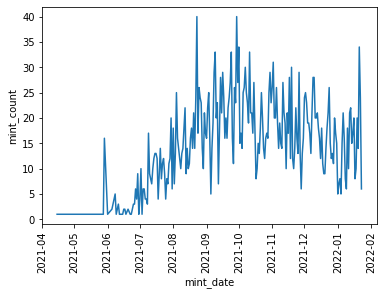

In [6]:
sns.lineplot(data=dmint.loc[dmint.owner_id=='0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647'], x='mint_date', y='mint_count')
plt.xticks(rotation='vertical')

(array([737881., 737911., 737942., 737972., 738003., 738034., 738064.,
        738095., 738125., 738156., 738187.]),
 <a list of 11 Text xticklabel objects>)

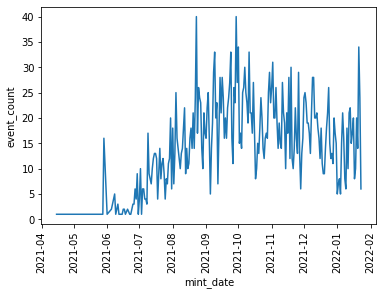

In [7]:
sns.lineplot(data=dmint.loc[dmint.owner_id=='0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647'], x='mint_date', y='event_count')
plt.xticks(rotation='vertical')

So we are talking about an average of 15-20 new different events everyday for years.. this is a big of strech - even for the most engaged people. The easy way to check this is to find a day where this user had minted POAP for non-virtual events in different countries. Let's see:

In [67]:
bot1 = poap.loc[(poap['owner_id']=='0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647')]

bot1.loc[(bot1.event_country!='') &
        (bot1.virtual_event!=True)].groupby(['mint_date']).agg(country_count=('event_country', 'nunique')).reset_index().sort_values('country_count', ascending=False).head(20)

,mint_date,country_count
123,2022-01-21,4
53,2021-10-11,4
72,2021-11-05,4
87,2021-12-01,4
33,2021-09-14,3
117,2022-01-13,3
52,2021-10-09,3
97,2021-12-11,3
88,2021-12-02,3
42,2021-09-24,3


I personally tried some days, but it seems 2021-11-05 is the perfect one:

In [69]:
poap.loc[(poap['owner_id']=='0xe5b1918d99f9b5b63817f6c9a7afda744ef1f647') 
         &(poap['mint_timestamp'].dt.strftime('%Y-%m-%d')=='2021-11-05')
         &(poap['event_country'] != '')
         &(poap['event_city'] != '')
         &(poap['virtual_event']!=True), ['event_name', 'event_city', 'event_country','virtual_event', 'mint_timestamp']]

,event_name,event_city,event_country,virtual_event,mint_timestamp
1754692,Charged Particles - Nested NFTs and DeFi NFTs,New York,USA,False,2021-11-05 07:57:50
1757704,"gm coffee: Coldie, Brinkman and Social Change",New York City,United States,False,2021-11-05 11:01:10
1758754,SushiSwap Onsen AMA - Kanpeki Finance,SushiSwap Discord,AMA Stage,False,2021-11-05 12:18:35
1763363,NFT Busan 2021,Busan,South Korea,False,2021-11-05 19:11:50
1764348,Not Fungible NFT NYC,New York,USA,False,2021-11-05 23:18:10


We can see that there are multiple NYC events but there is also a NFT Busan event in Korea at the same day! I think that if we add the number of events minted a day (which is huge) plus the above, this sounds like a bot or maybe a user that is more into collecting POAPs than actually participating - which is not of our most interest here, even though is interesting that there are people doing this type of 'farming'.

#### **Taking off potential bot accounts**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb304637c90>]],
      dtype=object)

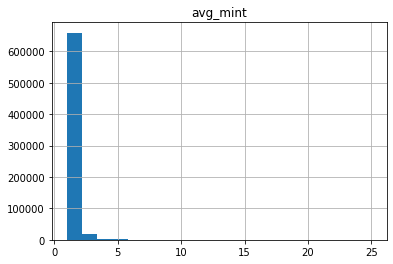

In [10]:
#Taking a loot at mint avg daily mints distribution
davg = dmint.groupby('owner_id').agg(avg_mint=('event_count', 'mean')).reset_index()
davg.loc[davg.avg_mint<=25].hist(bins=20)

I guess we could assume that the majority of people would be at 5 unique events a day max - and  we could consider this a reasonable amount of events to participate in day in a meaningful way. 

**Using the concept above to come up with a cleaned dataframe that would reflect better the real users**

In [11]:
#taking off potential bots from the dataframe
non_bot_users = davg.loc[davg.avg_mint<=5, 'owner_id'].unique()
poapc = poap.loc[poap.owner_id.isin(non_bot_users)].copy().drop(['is_top_x%', 'poaps_minted', 'unique_events_minted'], axis=1)

#marking the top X% minters _again

top_minters_v2 = poapc.groupby('owner_id').agg(poaps_minted=('token_id', 'nunique'), 
                                           unique_events_minted=('event_id', 'nunique')).reset_index().sort_values('poaps_minted', ascending=False)

percs = [.5, .4, .3, .2, .1]

top_minters_v2['is_top_x%'] = ''
for perc in percs:
    perc_max_count = int(len(top_minters_v2) * perc)
    top_minters_v2.iloc[0:perc_max_count, 3] = f"{perc*100:.0f}%"

#merging poap dt with the new labels
poapc = poapc.merge(top_minters_v2, on='owner_id', how='left')

poapc.head()

,token_created,event_created,event_id,event_tokenCount,event_transferCount,token_id,owner_id,token_transferCount,chain,event_fancy_id,...,virtual_event,event_template_id,event_host_id,private_event,owner_id_checksum,mint_timestamp,mint_date,poaps_minted,unique_events_minted,is_top_x%
0,1558995074,1558995074,14,84,96,1,0xea5ce2f9a33d36534ee3409d81322feb3f91ed8a,1,ethereum,ethdenver-19,...,False,0,0,False,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,2019-05-27 16:11:14,2019-05-27,5,5,20%
1,1558995074,1558995074,14,84,96,10,0xa3f0d54a263520375e01c17b8ffbd3190745bbd9,1,ethereum,ethdenver-19,...,False,0,0,False,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,2019-05-27 16:11:14,2019-05-27,1,1,50%
2,1558999607,1558999607,4,28,29,100,0x68f9d801c96ac6ccf562f3600cef77c4504449b6,1,ethereum,devcon2,...,False,0,0,False,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,2019-05-27 17:26:47,2019-05-27,22,22,10%
3,1559020637,1559018257,28,316,334,1000,0xdd6f702c2907ce401888d993d7dc185e7a824466,1,ethereum,ethny-19,...,False,0,0,False,0xDd6f702C2907ce401888D993D7Dc185e7a824466,2019-05-27 23:17:17,2019-05-27,1,1,50%
4,1588548343,1588539431,207,1197,1211,10000,0xcc95fd73c77bb7bb58714688e9333c05a388693e,1,ethereum,virtual-blockchain-week-2020-general-2020,...,False,0,0,False,0xcC95fd73C77bB7BB58714688e9333c05A388693e,2020-05-03 17:25:43,2020-05-03,2,2,30%


In [12]:
poapc.groupby('is_top_x%').agg(count=('owner_id', 'nunique'))

,count
is_top_x%,
,341195
10%,68238
20%,68239
30%,68239
40%,68239
50%,68239


In [13]:
top_minters_v2.head()

,owner_id,poaps_minted,unique_events_minted,is_top_x%
530935,0xc720427c80fc12fa191faaf63690964965c427d2,2338,861,10%
590707,0xdd82462f40d406c52a6548ac265d5c2423e4f528,1258,111,10%
14199,0x0506d39effcaefbc632cbe72c36c4d64759a665f,1201,1201,10%
370710,0x8b104344f397afc33ee55c743a0fbd7d956201cd,1197,1194,10%
228118,0x554333cb53e657f010a104c4e61bf4cc7db26f4c,1152,1151,10%


## Identifying the users that have the most POAP to track them

### How is this cohort different than the rest?

#### When have they started going to events? 

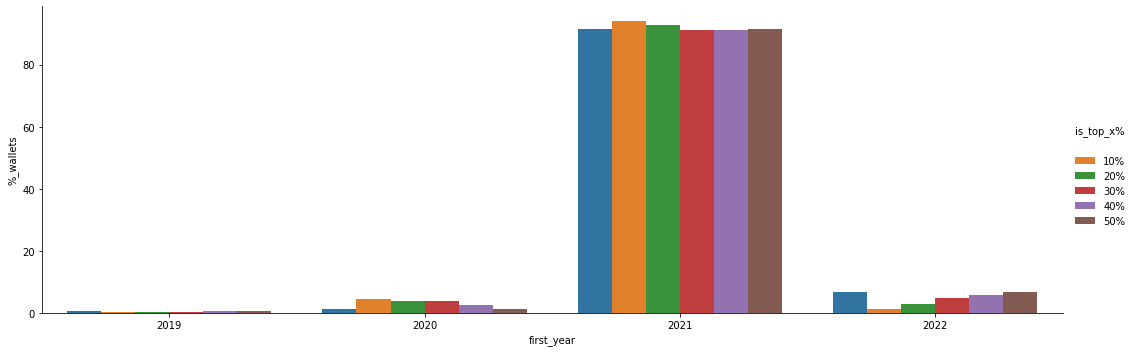

In [14]:
#getting these people first year
poapc['mint_year'] = poapc['mint_timestamp'].dt.year

fy = poapc.groupby(['owner_id','is_top_x%']).agg(wallet_count=('owner_id', 'nunique'), first_year=('mint_year', 'min')).reset_index()

fyc = fy.groupby(['is_top_x%', 'first_year']).agg(wallet_count=('wallet_count', 'sum'))
fyc['%_wallets'] = (fyc['wallet_count'] / fyc.groupby(level=0).transform('sum')['wallet_count']) * 100
fyc = fyc.reset_index()

sns.catplot(data=fyc, x='first_year', y='%_wallets', hue='is_top_x%', kind='bar', height=5, aspect=3)

#### Any first events common ?

In [15]:
#getting first events by wallet
poapc['event_rank'] = poapc.groupby('owner_id')['mint_timestamp'].rank('dense')

ft = poapc.loc[poapc.event_rank==1].copy()

ftg = ft.groupby(['is_top_x%', 'event_name']).agg(wallet_count=('owner_id', 'nunique'))
ftg['%_in_group'] = (ftg['wallet_count'] / ftg.groupby(level=0).transform('sum')['wallet_count']) * 100
ftg = ftg.reset_index().sort_values(['is_top_x%', '%_in_group'], ascending=[True, False])

ftg.loc[ftg['is_top_x%']!=''].groupby('is_top_x%').head(5)

,is_top_x%,event_name,wallet_count,%_in_group
9730,10%,Beanie x Farokh Ceasefire,2464,3.527913
12272,10%,NFTFY Official Launch Party - POAP,2251,3.222943
12891,10%,Rug Radio x Keith Grossman (President of TIME),1687,2.415417
13758,10%,VeeFriends x Christie's 10/01,1673,2.395372
12099,10%,Metamask 10 Million Users Party,1320,1.889953
16267,20%,Ethereal Summit 2021 - Attendee,2482,3.526069
14824,20%,Beanie x Farokh Ceasefire,2114,3.003268
19248,20%,VeeFriends x Christie's 10/01,1955,2.777383
17828,20%,POAP x Rocket Pool: Crossover Celebration,1851,2.629635
17338,20%,Metamask 10 Million Users Party,1390,1.974712


The above is the top 5 events by each user category (considering how high they are on the minting rank so top 10%, 20%, etc). Let's have a look on the top 30% altogether:

In [70]:
#getting first events by wallet
poapc['event_rank'] = poapc.loc[poapc['is_top_x%'].isin(['10%', '20%', '30%'])].groupby('owner_id')['mint_timestamp'].rank('dense')

ft = poapc.loc[poapc.event_rank==1].copy()

ftg = ft.groupby('event_name').agg(wallet_count=('owner_id', 'nunique'))
ftg['%_in_group'] = (ftg['wallet_count'] / ftg['wallet_count'].sum()) * 100
ftg = ftg.reset_index().sort_values('%_in_group', ascending=False)

ftg.head(10)

,event_name,wallet_count,%_in_group
1039,Beanie x Farokh Ceasefire,5901,2.813711
5374,NFTFY Official Launch Party - POAP,5057,2.411276
8011,VeeFriends x Christie's 10/01,4834,2.304945
5816,POAP x Rocket Pool: Crossover Celebration,3991,1.902986
5074,Metamask 10 Million Users Party,3952,1.884390
3966,Guild of Guardians Founder Badge,3669,1.749450
3357,Ethereal Summit 2021 - Attendee,3130,1.492445
6492,Rug Radio x Keith Grossman (President of TIME),2815,1.342247
2030,Curio Cards Christie's Auction 1,2760,1.316022
1660,CoinGecko 7th Anniversary Celebration,2589,1.234485


It seems that the most popular events are for the top 30% minters are:

- Beanie x Farokh Ceasefire
- NFTFY Official Launch Party - POAP
- VeeFriends x Christie's 10/01
- POAP x Rocket Pool: Crossover Celebration
- Metamask 10 Million Users Party

### Analyzing the most common events among the top 10% users

#### Any common/popular events?

In [16]:
# selecting only the top 10%
tt = poapc.loc[poapc['is_top_x%']=='10%']
ttg = tt.groupby('event_name').agg(wallet_count=('owner_id', 'nunique')).reset_index()
ttg['%_wallets'] = (ttg['wallet_count'] / len(tt.owner_id.unique())) * 100

ttg.sort_values('%_wallets', ascending=False).head(10)

,event_name,wallet_count,%_wallets
9792,POAP x Rocket Pool: Crossover Celebration,12111,17.748176
5686,Ethereals Moon Mission POAP #4,11680,17.116563
10729,Reddit / Rocket Pool Crossover Celebration,11663,17.091650
13276,VeeFriends x Christie's 10/01,10616,15.557314
5669,EthStaker Presents: Calm Before The Storm,10371,15.198277
3402,Curio Cards Christie's Auction 1,9662,14.159266
1821,Beanie x Farokh Ceasefire,8287,12.144260
13968,Zapper and Rocket Pool Crossover,7937,11.631349
3245,Crypto-Pills NYC,7674,11.245933
8236,Mask Ephemera- SearchLight in Pranksy's Place,7012,10.275799


#### What are the DAOs associated with these events? 

In [17]:
poapc.loc[poapc.event_name.isin(ttg.sort_values('%_wallets', ascending=False).head(10).event_name.unique()), 
          ['event_name', 'event_description']].drop_duplicates('event_name')

,event_name,event_description
9855,Beanie x Farokh Ceasefire,This POAP was created by FVCKRENDER to commemo...
11471,Reddit / Rocket Pool Crossover Celebration,Rocket Pool is hitting mainnet on October 6th ...
11774,VeeFriends x Christie's 10/01,"On 10/01/2021, the physical drawings of 5 VeeF..."
12013,Curio Cards Christie's Auction 1,This POAP was given to livestream watch party ...
12118,Crypto-Pills NYC,The Crypto Pills will be shown in Times Square...
12918,EthStaker Presents: Calm Before The Storm,"On October 3rd, 2021 Langers from the Rocket P..."
13364,Ethereals Moon Mission POAP #4,HOLDERS MUST BE IN ETHEREALS DISCORD IN ORDER ...
754420,POAP x Rocket Pool: Crossover Celebration,Rocket Pool is hitting mainnet on October 6th ...
899110,Zapper and Rocket Pool Crossover,Rocket Pool is launching on October 6 and is c...
1457494,Mask Ephemera- SearchLight in Pranksy's Place,"""SearchLight Mask Ephemera in Pranksy's Galler..."


- Descentraland
- RocketPool
- veeDAO

#### What are the characteristics of these events? 

- The events are mostly related to the NFT space, rather representing the culture or NFT events
- Also Rocket Pool appeared twice, which is nice among the whole NFT thing to have an important infrastructure project
- ETH staking seems like directly and indirectly (through Rocket Pool which is interesting)

In [18]:
# Trying to measure how much of these popular events on 2021 are NFT related

poapc['is_nft_related'] = False
poapc.loc[(poapc.event_name.str.contains('nft', case=False) )|
     (poapc.event_description.str.contains('nft', case=False)) |
     (poapc.event_url.str.contains('nft', case=False)), 'is_nft_related'] = True

#checking % of nft related POAP by user top% group

nftraw = poapc.groupby(['owner_id', 'is_top_x%', 'is_nft_related']).agg(event_count=('event_id', 'nunique'))
nftraw['%'] = (nftraw['event_count'] / nftraw.groupby(level=[0,1]).transform('sum')['event_count'])  * 100
nftraw = nftraw.reset_index()

nft = nftraw.groupby(['is_top_x%', 'is_nft_related']).agg(avg_percentage_of_poaps=('%', 'mean')).reset_index()
nft

,is_top_x%,is_nft_related,avg_percentage_of_poaps
0,,False,100.000000
1,,True,100.000000
2,10%,False,70.375674
3,10%,True,33.015985
4,20%,False,79.700520
5,20%,True,41.075734
6,30%,False,83.253378
7,30%,True,56.261849
8,40%,False,93.090702
9,40%,True,75.281235


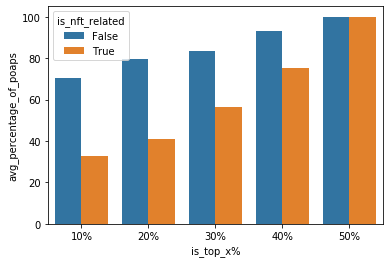

In [19]:
sns.barplot(data=nft.loc[nft['is_top_x%']!=''], x='is_top_x%', y='avg_percentage_of_poaps', hue='is_nft_related')

Ok.. so the people that mint the most are not as heavy on NFT, if they are not minting NFt related stuff is the popular options again?

In [20]:
# selecting only the top 10%
tt = poapc.loc[(poapc['is_top_x%']=='10%') & (poapc.is_nft_related==False)]
ttg = tt.groupby('event_name').agg(wallet_count=('owner_id', 'nunique')).reset_index()
ttg['%_wallets'] = (ttg['wallet_count'] / len(tt.owner_id.unique())) * 100

ttg.sort_values('%_wallets', ascending=False).head(10)

,event_name,wallet_count,%_wallets
7689,POAP x Rocket Pool: Crossover Celebration,12111,17.895561
4648,Ethereals Moon Mission POAP #4,11680,17.258703
8495,Reddit / Rocket Pool Crossover Celebration,11663,17.233584
10412,VeeFriends x Christie's 10/01,10616,15.686506
2750,Curio Cards Christie's Auction 1,9662,14.276849
1477,Beanie x Farokh Ceasefire,8287,12.245109
10899,Zapper and Rocket Pool Crossover,7937,11.727939
2615,Crypto-Pills NYC,7674,11.339323
6645,Mask Ephemera- SearchLight in Pranksy's Place,7012,10.361132
6885,Metamask 10 Million Users Party,6939,10.253266


### Analyzing the connections with DAOs and activities

#### Associating events with DAOs

In [53]:
dao_list_raw = list(daomembers.dao_name.unique()) #mixed cased letters
dao_list = [dao_name.lower() for dao_name in dao_list_raw]

#getting a list of all events to avoid running on duplicates rows
alev = poapc.loc[:, ['event_id', 'event_name', 'event_description', 'event_url']].copy().drop_duplicates('event_id')

#creating some support functions to make the loop cleaner

def find_dao_name_in_list(dao_name_list:list, dao_name_search:str):
    try:
        name_index = dao_name_list.index(dao_name_search)
        dao_name, search_status = dao_name_list[name_index], True
        return dao_name, search_status
    except ValueError:
        return 'not_found', False
   

def look_dao_on_dt_fields(dt_frame_row:object,dao_name_list:list,
                          search_fields:list=['event_name', 'event_url', 'event_description']):
    for field in search_fields:
        for dao in dao_name_list:
            if dao in dt_frame_row[field].lower():
                dao_name, status = find_dao_name_in_list(dao_name_list, dao)
                return dao_name,status
            else:
                continue
    
    return 'not_found', False


#running a loop to associate DAOs to events
dao_name_col = []
is_dao_associated_col = []
for index, row in alev.iterrows():
    dao_name, status = look_dao_on_dt_fields(row, dao_list)
    dao_name_col.append(dao_name)
    is_dao_associated_col.append(status)
    

alev['event_dao_name'] = dao_name_col
alev['is_dao_associated_event'] = is_dao_associated_col

In [55]:
alev.loc[alev.event_dao_name!='.'].tail(10)

,event_id,event_name,event_description,event_url,event_dao_name,is_dao_associated_event
3338385,6764,PunkDAO Inaugural Congress,5 punks came together to plan to keep the futu...,,dao,True
3338733,6348,HackFS 2021 Tech Mentor,Thanks for joining us for HackFS 2021! We can'...,https://hackfs.com,m,True
3338865,6765,Mustard Manor Guest,Thank you for staying with us at Mustard Manor...,,m,True
3338926,6345,Tracer Drop Episode #7: DAO Communities & Empl...,Tracer Drop is a live stream that is co-hosted...,https://www.youtube.com/playlist?list=PLxyjg08...,tracer,True
3338939,6766,Civics Unplugged Blockchain 101,Discussion about the potential of a Civics Unp...,https://www.civicsunplugged.org,vic,True
3339789,6431,Decentral Games' WSODG W35 - Wednesday - Septe...,Decentral Games WSODG - Wednesday - 6 person m...,https://decentral.games/events,decentral games,True
3342711,6775,Toast Test POAP Edition,Testing out setting up a POAP.,,poap,True
3346210,6750,spaceshibamountainTEST,test test,,tai,True
3346415,6804,PM Secret Eye #04,👁,https://www.polygonalmind.com/,secret,True
3347064,6797,testingtesttes2,this is a test,,testt,True


It's easy to see from the above that this method is not the best.. we would be probabl be making mistakes a good amount of times.. This would need more info.. only from descriptions or names/urls is hard to get __ host id from POAP could help, but we woul still need the address related to the event creation at least

#### Connecting the top minters to their DAO activity

Creating the dataset..

In [150]:
#creating dt fo have activity + POAP info

#getting POAP relevant info
pid = poapc.loc[:, ['owner_id_checksum', 'is_top_x%', 'poaps_minted', 'unique_events_minted']].drop_duplicates('owner_id_checksum')
pid = pid.rename(columns={'owner_id_checksum':'address', 'is_top_x%':'is_top_x%_poap_minter'})

#summarizing daoactivity dataframe


#merging into the daoactivity dt

daoactivity['action_type'] = 'other'
daoactivity.loc[daoactivity.type.isin(['snapshot_proposal_creation','daohaus_proposals' ]), 'action_type'] = 'proposal_creation'
daoactivity.loc[daoactivity.type.isin(['snapshot_votes','daohaus_votes' ]), 'action_type'] = 'votes'

dacsum = daoactivity.groupby(['address', 'action_type']).agg(number_of_actions=('count', 'sum')).reset_index()

#rotating th results to separate columns

dacs = dacsum.loc[dacsum.action_type.isin(['proposal_creation', 'votes'])]\
                  .pivot_table(index='address', columns='action_type', values='number_of_actions')\
                  .fillna(0)
# new_col_names = [f"{pair[0]}_{pair[1]}" for pair in dacs.columns]
# dacs.columns = dacs.columns.droplevel(0)
# dacs.columns = new_col_names
dacs = dacs.reset_index()

poapdao = pid.merge(dacs, on='address', how='left')

#getting the number of DAOs the wallets are in
ndaos = daomembers.groupby('address').agg(n_daos_active_in=('dao_name', 'nunique')).reset_index()
poapdao = poapdao.merge(ndaos, on='address', how='left')

poapdao = poapdao.fillna(0)

#creating some segmentation columns

poapdao['is_in_a_DAO'] = False
poapdao.loc[poapdao.n_daos_active_in>0, 'is_in_a_DAO'] = True

poapdao['has_a_vote'] = False
poapdao.loc[poapdao.votes>0, 'has_a_vote'] = True

poapdao['has_a_proposal'] = False
poapdao.loc[poapdao.proposal_creation>0, 'has_a_proposal'] = True

poapdao['has_activity'] = False
poapdao.loc[(poapdao.proposal_creation>0) | (poapdao.votes>0), 'has_activity'] = True

poapdao['total_activity'] = poapdao['votes'] + poapdao['proposal_creation']

poapdao.head()

,address,is_top_x%_poap_minter,poaps_minted,unique_events_minted,proposal_creation,votes,n_daos_active_in,is_in_a_DAO,has_a_vote,has_a_proposal,has_activity,total_activity
0,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,20%,5,5,0.0,0.0,0.0,False,False,False,False,0.0
1,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,50%,1,1,0.0,0.0,0.0,False,False,False,False,0.0
2,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,10%,22,22,0.0,4.0,4.0,True,True,False,True,4.0
3,0xDd6f702C2907ce401888D993D7Dc185e7a824466,50%,1,1,0.0,0.0,0.0,False,False,False,False,0.0
4,0xcC95fd73C77bB7BB58714688e9333c05A388693e,30%,2,2,0.0,0.0,0.0,False,False,False,False,0.0


**Proportion of top minters in DAOs**

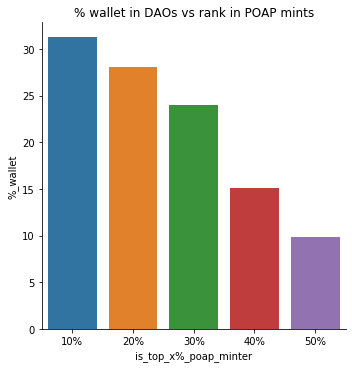

In [153]:
dps = poapdao.groupby(['is_top_x%_poap_minter', 'is_in_a_DAO']).agg(wallet_count=('address', 'nunique'))
dps['%_wallet'] = (dps['wallet_count'] / dps.groupby(level=0).transform('sum')['wallet_count']) * 100
dps = dps.reset_index()

sns.catplot(data=dps.loc[(dps.is_in_a_DAO==True) & (dps['is_top_x%_poap_minter']!='')], 
            x='is_top_x%_poap_minter', y='%_wallet', kind='bar')
plt.title('% wallet in DAOs vs rank in POAP mints')
plt.show()

**Proportion of top minters with at least one vote in a DAO**

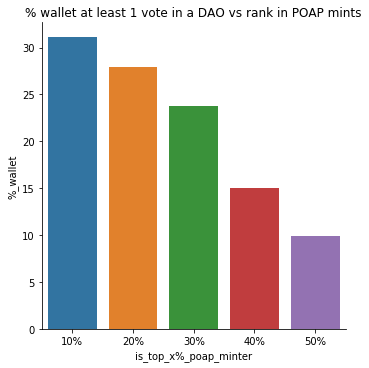

In [155]:
dps = poapdao.groupby(['is_top_x%_poap_minter', 'has_a_vote']).agg(wallet_count=('address', 'nunique'))
dps['%_wallet'] = (dps['wallet_count'] / dps.groupby(level=0).transform('sum')['wallet_count']) * 100
dps = dps.reset_index()

sns.catplot(data=dps.loc[(dps.has_a_vote==True) & (dps['is_top_x%_poap_minter']!='')], 
            x='is_top_x%_poap_minter', y='%_wallet', kind='bar')
plt.title('% wallet at least 1 vote in a DAO vs rank in POAP mints')
plt.show()

**Proportion of top minters with at least a proposal created or a vote in a DAO**

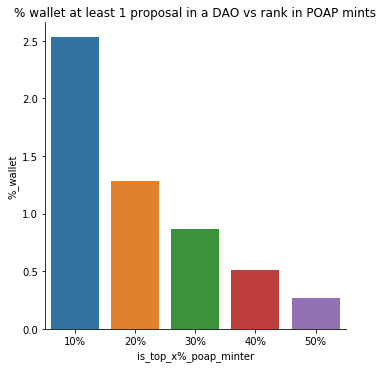

In [157]:
dps = poapdao.groupby(['is_top_x%_poap_minter', 'has_a_proposal']).agg(wallet_count=('address', 'nunique'))
dps['%_wallet'] = (dps['wallet_count'] / dps.groupby(level=0).transform('sum')['wallet_count']) * 100
dps = dps.reset_index()

sns.catplot(data=dps.loc[(dps.has_a_proposal==True) & (dps['is_top_x%_poap_minter']!='')], 
            x='is_top_x%_poap_minter', y='%_wallet', kind='bar')
plt.title('% wallet at least 1 proposal in a DAO vs rank in POAP mints')
plt.show()

**Proportion of top minters with at least proposal created in a DAO**

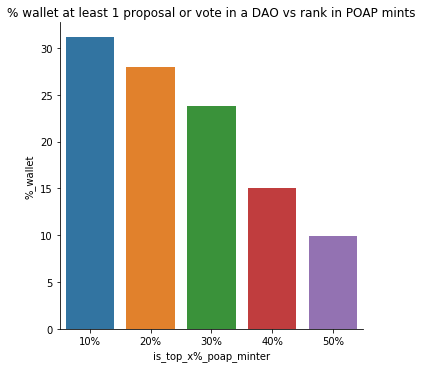

In [158]:
dps = poapdao.groupby(['is_top_x%_poap_minter', 'has_activity']).agg(wallet_count=('address', 'nunique'))
dps['%_wallet'] = (dps['wallet_count'] / dps.groupby(level=0).transform('sum')['wallet_count']) * 100
dps = dps.reset_index()

sns.catplot(data=dps.loc[(dps.has_activity==True) & (dps['is_top_x%_poap_minter']!='')], 
            x='is_top_x%_poap_minter', y='%_wallet', kind='bar')
plt.title('% wallet at least 1 proposal or vote in a DAO vs rank in POAP mints')
plt.show()

**What is the relatioship between number of events attended and DAO activity?**

In [250]:
poapdao.head()

,address,is_top_x%_poap_minter,poaps_minted,unique_events_minted,proposal_creation,votes,n_daos_active_in,is_in_a_DAO,has_a_vote,has_a_proposal,has_activity,total_activity
0,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,20%,5,5,0.0,0.0,0.0,False,False,False,False,0.0
1,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,50%,1,1,0.0,0.0,0.0,False,False,False,False,0.0
2,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,10%,22,22,0.0,4.0,4.0,True,True,False,True,4.0
3,0xDd6f702C2907ce401888D993D7Dc185e7a824466,50%,1,1,0.0,0.0,0.0,False,False,False,False,0.0
4,0xcC95fd73C77bB7BB58714688e9333c05A388693e,30%,2,2,0.0,0.0,0.0,False,False,False,False,0.0


Pearson correlation test for the association is 0.107, with p-value of 0.000


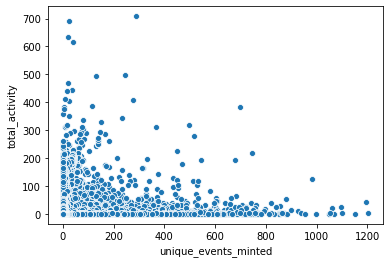

In [166]:
coef, p_value = stats.pearsonr(poapdao.loc[poapdao.total_activity<=1000, 'unique_events_minted'], # taking off 2k outlier
                               poapdao.loc[poapdao.total_activity<=1000, 'total_activity']) # taking off 2k outlier


print(f"Pearson correlation test for the association is {coef:.3f}, with p-value of {p_value:.3f}")

sns.scatterplot(data=poapdao.loc[poapdao.total_activity<=1000], x='unique_events_minted', y='total_activity') # taking off 2k outlier

**What is the relatioship between number of events attended and number of DAOs the wallets are member?**

Pearson correlation test for the association is 0.764, with p-value of 0.000


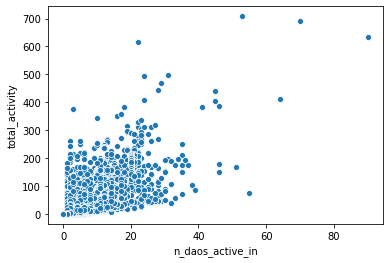

In [251]:
coef, p_value = stats.pearsonr(poapdao.loc[poapdao.total_activity<=1000, 'n_daos_active_in'], # taking off 2k outlier
                               poapdao.loc[poapdao.total_activity<=1000, 'total_activity']) # taking off 2k outlier


print(f"Pearson correlation test for the association is {coef:.3f}, with p-value of {p_value:.3f}")

sns.scatterplot(data=poapdao.loc[poapdao.total_activity<=1000], x='n_daos_active_in', y='total_activity') # taking off 2k outlier

Not very strong Pearson correlation coef here, we would like something far from 0 as possible. This indicates that the higher the number of events participated relates to higher chance of participating in DAO, but not necessarily a linear relatioship for more events > more activity.

**DAOs with more event engagement (considering their members activity)**

Working on dataset adjustments for this..

In [179]:
daosclean = daomembers.loc[:, ['address', 'dao_name']].copy().drop_duplicates(['address', 'dao_name'])
daosclean = daosclean.rename(columns={'address':'owner_id_checksum'})

daor = poapc.merge(daosclean, on='owner_id_checksum', how='left')

DAOs where its members has the most number of events attended:

In [263]:
daor_evs = daor.loc[daor.dao_name.notnull()].groupby('dao_name').agg(n_unique_events_attended_by_members=('event_id', 'nunique'))\
            .reset_index().sort_values('n_unique_events_attended_by_members', ascending=False)

daor_evs.head(10)

,dao_name,n_unique_events_attended_by_members
755,ENS,12874
1610,OpenDAO,7995
1650,PancakeSwap,7472
675,Decentraland,7202
291,Bankless DAO,6948
966,Gitcoin,6779
120,Aave,6617
278,BadgerDAO,6453
122,Aavegotchi,6449
2079,Sushi,6069


In [264]:
daor_evs.loc[daor_evs.dao_name.str.contains('diamond dao', case=False)]

,dao_name,n_unique_events_attended_by_members
699,Diamond DAO,203


DAOs where its members has the most number of tokens minted:

In [273]:
daor_mint = daor.loc[daor.dao_name.notnull()].groupby('dao_name').agg(token_mints=('token_id', 'nunique'))\
            .reset_index().sort_values('token_mints', ascending=False)

daor_mint.head(10)

,dao_name,token_mints
755,ENS,510031
1650,PancakeSwap,180245
675,Decentraland,152301
120,Aave,134793
966,Gitcoin,106580
1610,OpenDAO,82550
1513,NFT Finance,73914
1311,MATIC,71255
278,BadgerDAO,56779
282,Balancer,53748


In [266]:
daor_mint.loc[daor_mint.dao_name.str.contains('diamond dao', case=False)]

,dao_name,token_mints
699,Diamond DAO,223


**Let's do the same above but controlling for DAO size.. once this is playing a big effect**.

In [261]:
daocounts = daomembers.groupby('dao_name').agg(member_count=('address', 'nunique')).reset_index()

DAOs where its members has the most number of events attended (controlled by the DAO number of members):

In [268]:
#adding the total number of members
daor_evs = daor_evs.merge(daocounts, on='dao_name', how='left')
daor_evs['avg_event_per_member'] = daor_evs['n_unique_events_attended_by_members'] / daor_evs['member_count'] 

#for DAOs with at least 10 members
daor_evs.loc[daor_evs.member_count>=10].sort_values('avg_event_per_member', ascending=False).head(10)

,dao_name,n_unique_events_attended_by_members,member_count,avg_event_per_member
179,Unlock Community,1213,11,110.272727
165,bscpad,1280,13,98.461538
178,nftnetDAO,1217,14,86.928571
276,GTADAO,869,11,79.000000
125,dfei0,1552,21,73.904762
159,wujianli,1310,18,72.777778
304,sketchup,792,11,72.000000
195,yipit,1141,16,71.312500
313,ljc1993329dao,784,11,71.272727
286,wuwu,834,12,69.500000


In [269]:
daor_evs.loc[daor_evs.dao_name.str.contains('diamond dao', case=False)]

,dao_name,n_unique_events_attended_by_members,member_count,avg_event_per_member
846,Diamond DAO,203,18,11.277778


DAOs where its members has the most number of tokens minted (controlled by the DAO number of members):

In [274]:
#adding the total number of members
daor_mint = daor_mint.merge(daocounts, on='dao_name', how='left')
daor_mint['avg_mints_per_member'] = daor_mint['token_mints'] / daor_mint['member_count'] 

#for DAOs with at least 10 members
daor_mint.loc[daor_mint.member_count>=10].sort_values('avg_mints_per_member', ascending=False).head(10)

,dao_name,token_mints,member_count,avg_mints_per_member
120,ArcoiKun Community,4938,19,259.894737
49,Last Slice,11532,55,209.672727
230,nearcoin.eth,2115,11,192.272727
215,The eighth miracle,2267,12,188.916667
177,yipit,2907,16,181.687500
201,nftnetDAO,2438,14,174.142857
153,dfei0,3538,21,168.476190
223,bscpad,2169,13,166.846154
185,wujianli,2756,18,153.111111
279,857DAO,1563,11,142.090909


In [275]:
daor_mint.loc[daor_mint.dao_name.str.contains('diamond dao', case=False)]

,dao_name,token_mints,member_count,avg_mints_per_member
929,Diamond DAO,223,18,12.388889


**The effect of the first attendance/POAP mint on DAO activity**

Working the on the dataset adjustments..

In [215]:
# I will need to reassemble the proposals and votes dataframe to contemplate dates so I can compare to mint dates

#Snapshot

#proposals
snap_proposals['vote_timestamp'] = snap_proposals['created'].apply(lambda t: datetime.fromtimestamp(t/10e2))
snap_proposals['action_date'] = snap_proposals['vote_timestamp'].dt.date
sprops2 = snap_proposals.groupby(['author', 'space_name', 'action_date']).agg(count=('id', 'nunique')).reset_index()
sprops2 = sprops2.rename(columns={'author': 'address'})
sprops2['type'] = 'snapshot_proposal_creation'

#votes
snap_votes['vote_timestamp'] = snap_votes['created'].apply(lambda t: datetime.fromtimestamp(t/10e2))
snap_votes['action_date'] = snap_votes['vote_timestamp'].dt.date
svotes2 = snap_votes.groupby(['voter', 'space_name','action_date']).agg(count=('proposal_id', 'nunique')).reset_index()
svotes2 = svotes2.rename(columns={'voter': 'address'})
svotes2['type'] = 'snapshot_votes'

#getting DaoHaus votes and proposals

#proposals
dh_proposals['action_date'] = dh_proposals['created_at'].dt.date
dhprops2 = dh_proposals.groupby(['applicant_normalized', 'dao_name','action_date']).agg(count=('proposal_id', 'nunique')).reset_index()
dhprops2 = dhprops2.rename(columns={'applicant_normalized': 'address'})
dhprops2['type'] = 'daohaus_proposals'

#votes
dh_votes['action_date'] = dh_votes['created_at'].dt.date
dhvotes2 = dh_votes.groupby(['address_normalized', 'dao_name', 'action_date']).agg(count=('id', 'nunique')).reset_index()
dhvotes2 = dhvotes2.rename(columns={'address_normalized':'address'})
dhvotes2['type'] = 'daohaus_votes'


daoact = pd.concat([sprops2, svotes2, dhprops2, dhvotes2])

#creating unified action type

action_types = {
    'snapshot_proposal_creation': 'proposal_creation',
    'snapshot_votes': 'vote',
    'daohaus_proposals': 'proposal_creation',
    'daohaus_votes': 'vote'
}

daoact['action_type'] = daoact['type'].apply(lambda t: action_types[t])
daoact.head()

/Users/fernandomeira/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,action_date,address,count,dao_name,space_name,type,action_type
0,2021-02-12,0x000000000057E8ABd581828A2b40076852C0bA6E,1,NaN,Indexed Finance,snapshot_proposal_creation,proposal_creation
1,2021-03-03,0x000000000057E8ABd581828A2b40076852C0bA6E,1,NaN,Indexed Finance,snapshot_proposal_creation,proposal_creation
2,2021-03-23,0x000000000057E8ABd581828A2b40076852C0bA6E,1,NaN,Indexed Finance,snapshot_proposal_creation,proposal_creation
3,2021-04-09,0x000000000057E8ABd581828A2b40076852C0bA6E,1,NaN,Indexed Finance,snapshot_proposal_creation,proposal_creation
4,2021-04-20,0x000000000057E8ABd581828A2b40076852C0bA6E,1,NaN,Indexed Finance,snapshot_proposal_creation,proposal_creation


After the first event regardless of what it was

In [237]:
#adjusting ranks for the NaNs
poapc['event_rank'] = poapc['event_rank'].fillna(1)

#getting the people where their first event was presencial
fp = poapc.loc[(poapc.event_rank==1), ['owner_id_checksum', 'mint_date']]


#merging with the daoactivity dataframe
actv = daoact.copy().merge(fp, right_on='owner_id_checksum', left_on='address', how='left')

actv_clean = actv.loc[actv.mint_date.notnull()].copy()
actv_clean['action_is_after_first_event'] = np.where(actv_clean['action_date']>actv_clean['mint_date'], True, False)

print(f"The total number of wallets for this case is: {len(actv_clean.owner_id_checksum.unique()):,} \n")

#Getting the sum by address
actv_sum = actv_clean.groupby(['address', 'action_is_after_first_event']).agg(action_count=('count', 'sum')).reset_index()

#getting the stats

test_v, p_value_dif = stats.ttest_ind(actv_sum.loc[actv_sum.action_is_after_first_event==True, 'action_count'],
                                      actv_sum.loc[actv_sum.action_is_after_first_event==False, 'action_count'],
                                     equal_var=False)

print(f"The difference for the averages below have t-test pvalue of: {p_value_dif}")

#getting the final summary

actv_sum.groupby('action_is_after_first_event').agg(avg_activity_count_per_wallet=('action_count', 'mean'))

The total number of wallets for this case is: 106,577 

The difference for the averages below have t-test pvalue of: 8.670194885051644e-46


,avg_activity_count_per_wallet
action_is_after_first_event,
False,5.704575
True,7.298655


When the first event was presencial

In [236]:
#adjusting ranks for the NaNs
poapc['event_rank'] = poapc['event_rank'].fillna(1)

#getting the people where their first event was presencial
fp = poapc.loc[(poapc.event_rank==1) & (poapc.virtual_event==False), ['owner_id_checksum', 'mint_date']]


#merging with the daoactivity dataframe
actv = daoact.copy().merge(fp, right_on='owner_id_checksum', left_on='address', how='left')

actv_clean = actv.loc[actv.mint_date.notnull()].copy()
actv_clean['action_is_after_first_event'] = np.where(actv_clean['action_date']>actv_clean['mint_date'], True, False)

print(f"The total number of wallets for this case is: {len(actv_clean.owner_id_checksum.unique()):,} \n")

#Getting the sum by address
actv_sum = actv_clean.groupby(['address', 'action_is_after_first_event']).agg(action_count=('count', 'sum')).reset_index()

#getting the stats

test_v, p_value_dif = stats.ttest_ind(actv_sum.loc[actv_sum.action_is_after_first_event==True, 'action_count'],
                                      actv_sum.loc[actv_sum.action_is_after_first_event==False, 'action_count'],
                                     equal_var=False)

print(f"The difference for the averages below have t-test pvalue of: {p_value_dif}")

#getting the final summary

actv_sum.groupby('action_is_after_first_event').agg(avg_activity_count_per_wallet=('action_count', 'mean'))

The total number of wallets for this case is: 22,720 

The difference for the averages below have t-test pvalue of: 0.0037623412089199423


,avg_activity_count_per_wallet
action_is_after_first_event,
False,6.971426
True,7.757339


When the first event was virtual

In [235]:
#adjusting ranks for the NaNs
poapc['event_rank'] = poapc['event_rank'].fillna(1)

#getting the people where their first event was presencial
fp = poapc.loc[(poapc.event_rank==1) & (poapc.virtual_event==True), ['owner_id_checksum', 'mint_date']]



#merging with the daoactivity dataframe
actv = daoact.copy().merge(fp, right_on='owner_id_checksum', left_on='address', how='left')

actv_clean = actv.loc[actv.mint_date.notnull()].copy()
actv_clean['action_is_after_first_event'] = np.where(actv_clean['action_date']>actv_clean['mint_date'], True, False)

print(f"The total number of wallets for this case is: {len(actv_clean.owner_id_checksum.unique()):,} \n")

#Getting the sum by address
actv_sum = actv_clean.groupby(['address', 'action_is_after_first_event']).agg(action_count=('count', 'sum')).reset_index()

#getting the stats

test_v, p_value_dif = stats.ttest_ind(actv_sum.loc[actv_sum.action_is_after_first_event==True, 'action_count'],
                                      actv_sum.loc[actv_sum.action_is_after_first_event==False, 'action_count'],
                                     equal_var=False)

print(f"The difference for the averages below have t-test pvalue of: {p_value_dif}")

#getting the final summary

actv_sum.groupby('action_is_after_first_event').agg(avg_activity_count_per_wallet=('action_count', 'mean'))

The total number of wallets for this case is: 85,828 

The difference for the averages below have t-test pvalue of: 7.471618990015864e-69


,avg_activity_count_per_wallet
action_is_after_first_event,
False,5.251427
True,7.054921


After first presencial event (regardless if this was the first or not)

In [248]:
#adjusting ranks for the NaNs
poapc['event_rank'] = poapc['event_rank'].fillna(1)

#getting the people where their first event was presencial
fp_root = poapc.loc[poapc.virtual_event==False]
fp = fp_root.loc[fp_root.loc[fp_root.virtual_event==False].groupby('owner_id')['event_rank'].idxmin(), ['owner_id_checksum', 'mint_date']]

                 
#merging with the daoactivity dataframe
actv = daoact.copy().merge(fp, right_on='owner_id_checksum', left_on='address', how='left')

actv_clean = actv.loc[actv.mint_date.notnull()].copy()
actv_clean['action_is_after_first_event'] = np.where(actv_clean['action_date']>actv_clean['mint_date'], True, False)

print(f"The total number of wallets for this case is: {len(actv_clean.owner_id_checksum.unique()):,} \n")

#Getting the sum by address
actv_sum = actv_clean.groupby(['address', 'action_is_after_first_event']).agg(action_count=('count', 'sum')).reset_index()

#getting the stats

test_v, p_value_dif = stats.ttest_ind(actv_sum.loc[actv_sum.action_is_after_first_event==True, 'action_count'],
                                      actv_sum.loc[actv_sum.action_is_after_first_event==False, 'action_count'],
                                     equal_var=False)

print(f"The difference for the averages below have t-test pvalue of: {p_value_dif}")

#getting the final summary

actv_sum.groupby('action_is_after_first_event').agg(avg_activity_count_per_wallet=('action_count', 'mean'))

The total number of wallets for this case is: 47,320 

The difference for the averages below have t-test pvalue of: 3.906201481625367e-15


,avg_activity_count_per_wallet
action_is_after_first_event,
False,7.280355
True,8.635760


After first virtual event (regardless if this was the first or not)

In [249]:
#adjusting ranks for the NaNs
poapc['event_rank'] = poapc['event_rank'].fillna(1)

#getting the people where their first event was presencial
fp_root = poapc.loc[poapc.virtual_event==True]
fp = fp_root.loc[fp_root.loc[fp_root.virtual_event==True].groupby('owner_id')['event_rank'].idxmin(), ['owner_id_checksum', 'mint_date']]

                 
#merging with the daoactivity dataframe
actv = daoact.copy().merge(fp, right_on='owner_id_checksum', left_on='address', how='left')

actv_clean = actv.loc[actv.mint_date.notnull()].copy()
actv_clean['action_is_after_first_event'] = np.where(actv_clean['action_date']>actv_clean['mint_date'], True, False)

print(f"The total number of wallets for this case is: {len(actv_clean.owner_id_checksum.unique()):,} \n")

#Getting the sum by address
actv_sum = actv_clean.groupby(['address', 'action_is_after_first_event']).agg(action_count=('count', 'sum')).reset_index()

#getting the stats

test_v, p_value_dif = stats.ttest_ind(actv_sum.loc[actv_sum.action_is_after_first_event==True, 'action_count'],
                                      actv_sum.loc[actv_sum.action_is_after_first_event==False, 'action_count'],
                                     equal_var=False)

print(f"The difference for the averages below have t-test pvalue of: {p_value_dif}")

#getting the final summary

actv_sum.groupby('action_is_after_first_event').agg(avg_activity_count_per_wallet=('action_count', 'mean'))

The total number of wallets for this case is: 96,018 

The difference for the averages below have t-test pvalue of: 8.499720978927374e-44


,avg_activity_count_per_wallet
action_is_after_first_event,
False,5.586202
True,6.986375
